In [24]:
%load_ext autoreload
%autoreload 2

from charting import create_performance_chart
from utils import get_llm_answers, get_llm_stats, load_all_llm_answers_from_json, model_clean
from auto_eval import (
    create_all_llm_eval_messages, 
    extract_all_scores, 
    create_auto_eval_json, 
    get_llm_eval_responses, 
    score_multiple_choice_answers,
    validation_func,
    extract_valid_json,
)
from multiple_choice import construct_multiple_choice_question
from hotz_reflection import construct_hotz_reflection_question

from datetime import datetime
import pandas as pd
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variables

In [25]:
answer_models = [
    ("gpt-4-turbo-preview", "litellm"),
    ("gpt-4o", "litellm"),
    ("gpt-4o-mini-2024-07-18", "litellm"),
    ("bedrock/meta.llama3-70b-instruct-v1:0", "litellm"),
    ("Meta-Llama-3-1-70B-Instruct-ostu.eastus.models.ai.azure.com", "custom"),
    ("Meta-Llama-3-1-405B-Instruct-jjo.eastus.models.ai.azure.com", "custom"),
    ("mistral-large-latest", "custom"),
    ("mistral/open-mixtral-8x22b", "litellm"), 
    ("claude-3-opus-20240229", "litellm"), 
    ("vertex_ai/gemini-1.5-pro", "litellm"), 
    ("command-r-plus", "litellm"), 
    ("claude-3-5-sonnet-20240620", "litellm"),
]

answer_rounds = 10 # Number of rounds of questions to ask each model
answer_hyperparams = {
    'batch_size': 5, # Max number of questions to send to a model at once (10 is sensible)
    'temperature': 0, # 0 is default and the most deterministic
    'max_tokens': 2048, # 2048 works for most models, but may have to be reduced for some models
    'num_retries': 5, # Number of times to retry a question if it fails
}

multiple_choice_questions = True

if multiple_choice_questions is False:
    # Auto evaluation is only supported for open-ended questions and involves an LLM evaluating results against a set of criteria
    # Criteria can be found in `auto_eval.py` create_eval_prompt function
    auto_eval_rounds = 1 # Number of rounds of auto evaluation to run to then average the scores
    auto_eval_model = ("gpt-4o", "custom"),
    auto_eval_hyperparams= {
        'temperature': 0,
        'max_tokens': 2048,
        'batch_size': 30,
    }

hotz_reflection = False
benchmark_name = 'Benchmark' if not multiple_choice_questions else 'Multi-Benchmark'
date_now = datetime.now().strftime('%Y-%m-%d') #'2024-06-10'
folder_name = f"{date_now}-{benchmark_name}" #"2024-06-21-Multi-Benchmark (temp=0)" 

answers_save_path = f"./{folder_name}/llm_outputs"
answers_hotz_save_path = f"./{folder_name}/hotz_reflection"
auto_eval_save_path = f"./{folder_name}/auto_eval_outputs"
auto_eval_hotz_save_path = f"./{folder_name}/auto_eval_hotz_outputs"
stats_save_path = f"./{folder_name}/tables_and_charts"


execution_steps = [
    "get_llm_answers",
    # "hotz_reflection",
    "evaluate_answers",
    "generate_statistics", 
]

## Run Benchmark

In [26]:
def calc_incomplete_llm_answers(all_llm_answers, auto_eval_save_path, sub_eval_folders, date_now):
    all_llm_evals = load_all_llm_answers_from_json(auto_eval_save_path,
        prefix_replace='auto_eval-', sub_folders=sub_eval_folders)
    skip_evals = set(all_llm_evals.keys() & set(all_llm_answers.keys()))
    print(f'Skipping existing LLM evals (in {date_now} folder):', skip_evals)
    incomplete_llm_answers = {model: value for model, value in all_llm_answers.items() 
                               if model_clean(model) not in skip_evals}
    return incomplete_llm_answers

1. GETTING LLM ANSWERS

----- Round: 1 of 10 -----
Skipping existing LLM answers (in ./2024-07-20-Multi-Benchmark/llm_outputs/round_1 folder): ['claude-3-5-sonnet-20240620', 'claude-3-opus-20240229', 'command-r-plus', 'gemini-1_5-pro', 'gpt-4-turbo-preview', 'gpt-4o-mini-2024-07-18', 'gpt-4o', 'Meta-Llama-3-1-405B-Instruct-jjo_eastus_models_ai_azure_com', 'Meta-Llama-3-1-70B-Instruct-ostu_eastus_models_ai_azure_com', 'meta_llama3-70b-instruct-v1_0', 'mistral-large-latest', 'open-mixtral-8x22b']

----- Round: 2 of 10 -----
Skipping existing LLM answers (in ./2024-07-20-Multi-Benchmark/llm_outputs/round_2 folder): ['claude-3-5-sonnet-20240620', 'claude-3-opus-20240229', 'command-r-plus', 'gemini-1_5-pro', 'gpt-4-turbo-preview', 'gpt-4o-mini-2024-07-18', 'gpt-4o', 'Meta-Llama-3-1-405B-Instruct-jjo_eastus_models_ai_azure_com', 'Meta-Llama-3-1-70B-Instruct-ostu_eastus_models_ai_azure_com', 'meta_llama3-70b-instruct-v1_0', 'mistral-large-latest', 'open-mixtral-8x22b']

----- Round: 3 of 10 -

,mean_score,std_dev_score,z_interval_error,ci_lower,ci_upper,output_count,invalid_outputs
model,,,,,,,
Meta-Llama-3-1-405B-Instruct-jjo_eastus_models_ai_azure_com,54.666667,49.864923,5.642747,49.000000,60.333333,300.0,0.0
claude-3-5-sonnet-20240620,50.666667,50.079090,5.666983,45.000000,56.333333,300.0,0.0
claude-3-opus-20240229,44.333333,49.760855,5.630971,38.666667,50.000000,300.0,0.0
gpt-4o,42.000000,49.438317,5.594472,36.666667,47.666667,300.0,0.0
gpt-4-turbo-preview,36.666667,48.269958,5.462260,31.333333,42.008333,300.0,0.0
Meta-Llama-3-1-70B-Instruct-ostu_eastus_models_ai_azure_com,34.333333,47.561496,5.382090,29.000000,39.666667,300.0,5.0
gpt-4o-mini-2024-07-18,33.333333,47.219216,5.343357,28.000000,38.666667,300.0,0.0
gemini-1_5-pro,31.000000,46.326600,5.242348,26.000000,36.333333,300.0,6.0
mistral-large-latest,29.666667,45.755153,5.177683,24.666667,35.000000,300.0,0.0


c:\Users\JamesHuckle\OneDrive - AutogenAI\Documents\autogenai-code\LLM Eval Paper\charting.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  


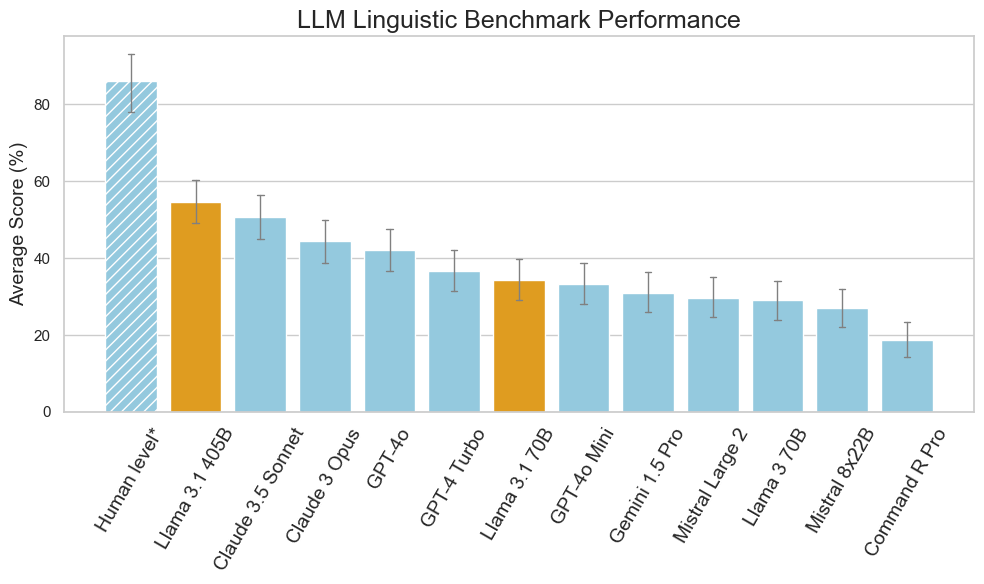

-- DONE STATS --



In [27]:
# Load in benchmark questions
if multiple_choice_questions:
    benchmark_questions = json.load(open('linguistic_benchmark_multi_choice.json', 'r'))
    sub_eval_folders = ['']
    def answer_validation_func(x):
        return validation_func(x, json_key='ANSWER', list_of_values=['A', 'B', 'C', 'D'])
else:
    benchmark_questions = json.load(open('linguistic_benchmark.json', 'r'))
    sub_eval_folders = [f'/round_{r+1}' for r in range(auto_eval_rounds)]
sub_answer_folders = [f'/round_{r+1}' for r in range(answer_rounds)]


if "get_llm_answers" in execution_steps:
    print('1. GETTING LLM ANSWERS')
    # Load in any existing answers and evals to avoid overwriting them
    for n in range(answer_rounds):
        print(f'\n----- Round: {n+1} of {answer_rounds} -----')
        answer_save_path_round = f"{answers_save_path}/round_{n+1}"
        all_llm_answers = load_all_llm_answers_from_json(answer_save_path_round,
            prefix_replace='final_answers-')
        print(f'Skipping existing LLM answers (in {answer_save_path_round} folder):', list(all_llm_answers.keys()))
        answer_models_run = [model for model in answer_models 
                             if model_clean(model[0]) not in all_llm_answers.keys()]
        questions = benchmark_questions.copy()
        if multiple_choice_questions:
            questions = {}
            for model, llm_service in answer_models_run:
                clean_model = model_clean(model)
                questions[clean_model] = benchmark_questions.copy()
                for q in questions[clean_model]:
                    prompt, correct_letter = construct_multiple_choice_question(q)
                    q.update({'multi_choice_question': prompt, 'correct_letter': correct_letter})
        all_llm_answers = await get_llm_answers(
            questions,
            answer_models_run,
            answer_hyperparams,
            answer_save_path_round,
            multiple_choice_questions,
            validation_func=answer_validation_func if multiple_choice_questions else lambda x: True
        )
    print('-- DONE ANSWERS --\n')


if "hotz_reflection" in execution_steps:
    print('1.5 GETTING HOTZ REFLECTION ANSWERS')
    # Load in any existing answers and evals to avoid overwriting them
    for n in range(answer_rounds):
        print(f'\n----- Round: {n+1} of {answer_rounds} -----')
        answer_save_path_round = f"{answers_save_path}/round_{n+1}"
        answer_hotz_save_path_round = f"{answers_hotz_save_path}/round_{n+1}"
        all_llm_answers = load_all_llm_answers_from_json(answer_save_path_round,
            prefix_replace='final_answers-')
        all_hotz_llm_answers = load_all_llm_answers_from_json(answer_hotz_save_path_round,
            prefix_replace='final_answers-')
        print(f'Skipping existing LLM answers (in {answer_hotz_save_path_round} folder):', list(all_hotz_llm_answers.keys()))
        answer_models_run = [model for model in answer_models 
                            if model_clean(model[0]) not in all_hotz_llm_answers.keys()]
        all_llm_questions = {model: info.to_dict('records') for model, info in all_llm_answers.items()}
        if multiple_choice_questions:
            for model, questions in all_llm_questions.items():
                for q in questions:
                    prompt = construct_hotz_reflection_question(q)
                    q.update({'multi_choice_question_pre': q['multi_choice_question']})
                    q.update({'model_answer_pre': q['model_answer']})
                    q.update({'multi_choice_question': prompt})

        all_llm_answers = await get_llm_answers(
            all_llm_questions,
            answer_models_run,
            answer_hyperparams,
            answer_hotz_save_path_round,
            multiple_choice_questions,
            validation_func=answer_validation_func if multiple_choice_questions else lambda x: True
        )
    print('-- DONE ANSWERS --\n')


if "evaluate_answers" in execution_steps:
    print('2. EVALUATING ANSWERS')
    all_llm_answers = load_all_llm_answers_from_json(answers_save_path,
        prefix_replace='final_answers-', sub_folders=sub_answer_folders)
    if multiple_choice_questions:
        incomplete_llm_answers = all_llm_answers
        all_llm_evals = score_multiple_choice_answers(incomplete_llm_answers, auto_eval_save_path)
        if hotz_reflection:
            print('\nEvaluate Hotz Reflections')
            all_llm_answers = load_all_llm_answers_from_json(answers_hotz_save_path,
                prefix_replace='final_answers-', sub_folders=sub_answer_folders)
            incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_answers, auto_eval_hotz_save_path,
                                                                sub_eval_folders, date_now)
            all_llm_evals = score_multiple_choice_answers(incomplete_llm_answers, auto_eval_hotz_save_path)
    else:
        all_llm_eval_messages = create_all_llm_eval_messages(all_llm_answers, benchmark_questions)
        for n in range(auto_eval_rounds):
            print(f'- Round: {n+1} of {auto_eval_rounds} -')
            incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_eval_messages, auto_eval_save_path,
                                                                 [f'/round_{n+1}'], date_now)
            all_llm_eval_responses = await get_llm_eval_responses(
                incomplete_llm_answers,
                model_info=auto_eval_model, 
                hyperparams=auto_eval_hyperparams,
                validation_func=lambda x: validation_func(x, json_key='score', 
                    list_of_values=[0, 20, 40, 60, 80, 100])
            )
            all_llm_scores = extract_all_scores(all_llm_eval_responses)
            auto_eval_save_path_n = f"{auto_eval_save_path}/round_{n+1}"
            all_auto_results = create_auto_eval_json(
                all_llm_scores, 
                all_llm_eval_responses, 
                all_llm_answers, 
                benchmark_questions, 
                auto_eval_save_path_n
            )
    print('-- DONE EVAL --\n')


if "generate_statistics" in execution_steps:
    print('3. GENERATING STATISTICS')
    all_stats_dfs = {}
    save_info = [{
        'path': auto_eval_save_path, 
        'chart_title': 'LLM Linguistic Benchmark Performance',
        'type': '',
    }]
    if hotz_reflection:
        save_info.append({
            'path': auto_eval_hotz_save_path, 
            'chart_title': 'LLM Linguistic Benchmark Performance (Hotz Reflection)',
            'type': '-Hotz',
        })
    for info in save_info:
        save_path = info['path']
        chart_title = info['chart_title']
        info_type = info['type']
        print('Eval for path:', save_path)
        all_llm_evals = load_all_llm_answers_from_json(
            save_path, 
            prefix_replace='auto_eval-',
            sub_folders=sub_eval_folders,
        )
        stats_df = get_llm_stats(all_llm_evals, stats_save_path, file_suffix=info_type, bootstrap_n=10000)
        if multiple_choice_questions:
            for model, evals_df in all_llm_evals.items():
                #evals_df['invalid_answer_letter'] = evals_df.apply(lambda x: x['json_answer_letter'] not in ['A', 'B', 'C', 'D'], axis=1)
                incorrect_letter_count = evals_df['invalid_answer_letter'].sum()
                print(model, incorrect_letter_count)
                stats_df.loc[model, 'invalid_outputs'] = incorrect_letter_count

        display(stats_df)
        barplot, plt = create_performance_chart(stats_df.reset_index(), chart_title, 
            highlight_models=['Llama 3.1 405B', 'Llama 3.1 70B'],)
        barplot.figure.savefig(f"{stats_save_path}/performance_chart{info_type}.png")
        plt.show()
        all_stats_dfs[chart_title] = stats_df
    print('-- DONE STATS --\n')

In [28]:
raise

RuntimeError: No active exception to reraise

## Inspect Answers for a given model

In [ ]:
# model = 'gpt-4-turbo-preview'
# answers = all_llm_evals[model][['question', 'model_answer', 'json_answer', 'correct_letter', 'score']]
# for row in answers.to_dict('records'):
#     print('--------------')
#     print('\nQuestion\n', row['question'])
#     print('\nModel Answer\n', row['model_answer'])
#     print('\nJson Answer\n', row['json_answer'])
#     print('\nCorrect Letter\n', row['correct_letter'])    
#     print('\nScore\n', row['score'])

## Inspect Hotz Reflections Performance

In [ ]:
all_llm_evals = load_all_llm_answers_from_json(
    auto_eval_hotz_save_path, 
    prefix_replace='auto_eval-',
    sub_folders=sub_eval_folders,
)

answer_change_stats = {}
for model, model_evals in all_llm_evals.items():
    model_evals['json_answer_letter_pre'] = model_evals['model_answer_pre'].map(extract_valid_json).map(lambda x: None if x is None else x['ANSWER'])

    compare_letters = model_evals[['json_answer_letter', 'json_answer_letter_pre', 'correct_letter']].copy()
    compare_letters['changed_answer'] = compare_letters['json_answer_letter'] != compare_letters['json_answer_letter_pre']
    compare_letters['changed_answer_perc'] = (compare_letters['changed_answer'] / len(compare_letters)) * 100
    compare_letters['correct'] = compare_letters['json_answer_letter'] == compare_letters['correct_letter']
    compare_letters['correct_pre'] = compare_letters['json_answer_letter_pre'] == compare_letters['correct_letter']

    compare_letters[['correct', 'correct_pre', 'changed_answer_perc']].sum()
    answer_change_stats[model] = compare_letters[['correct_pre', 'correct', 'changed_answer_perc']].sum()
final_answer_change_df = pd.DataFrame(answer_change_stats).transpose().sort_values('correct', ascending=False)
final_answer_change_df.rename(columns={
    'correct_pre': 'Correct (pre-reflection)', 
    'correct': 'Correct (post-reflection)', 
    }, inplace=True)
final_answer_change_df

KeyError: 'correct'

In [ ]:
hotz_ref = 'LLM Liguisitc Benchmark Performance (Hotz Reflection)'
ref = 'LLM Liguisitc Benchmark Performance'

all_stats_dfs[hotz_ref]['mean_score_pre'] = all_stats_dfs[ref]['mean_score']

all_stats_dfs[hotz_ref]['diff'] = all_stats_dfs[hotz_ref]['mean_score'] - all_stats_dfs[hotz_ref]['mean_score_pre']
all_stats_dfs[hotz_ref]
diff_from_pre = all_stats_dfs[hotz_ref][['mean_score', 'mean_score_pre', 'diff']]
diff_from_pre

In [ ]:
diff_from_pre_final_raw = diff_from_pre.merge(final_answer_change_df[['changed_answer_perc']], left_index=True, right_index=True)
diff_from_pre_final = diff_from_pre_final_raw[['mean_score_pre', 'mean_score', 'diff', 'changed_answer_perc']].round(0)
diff_from_pre_final.rename(columns={
    "mean_score_pre": "Pre-Reflection Score",
    "mean_score": "Post-Reflection Score",
    "diff": "Difference",
    "changed_answer_perc": "Answers Changed (%)",
}, inplace=True)
#diff_from_pre_final = diff_from_pre_final.astype(int).astype(str) + '%'
diff_from_pre_final

,Pre-Reflection Score,Post-Reflection Score,Difference,Answers Changed (%)
claude-3-5-sonnet-20240620,50.0,45.0,-5.0,25.0
gpt-4o,44.0,42.0,-2.0,10.0
claude-3-opus-20240229,43.0,40.0,-3.0,12.0
gpt-4-turbo-preview,35.0,34.0,-1.0,15.0
gemini-1_5-pro,31.0,32.0,1.0,30.0
open-mixtral-8x22b,31.0,30.0,-1.0,5.0
mistral-large-latest,29.0,29.0,0.0,9.0
meta_llama3-70b-instruct-v1_0,29.0,28.0,-2.0,46.0
command-r,25.0,23.0,-2.0,7.0
gemini-1_0-pro,21.0,21.0,-1.0,7.0


In [ ]:
diff_from_pre_final['Answers Changed (%)'].mean()

16.6

# Inspect Auto Eval Consistancy

In [ ]:
all_llm_evals = load_all_llm_answers_from_json(
    auto_eval_save_path, 
    prefix_replace='auto_eval-',
    sub_folders=sub_eval_folders,
)
models = list(all_llm_evals.keys())


model = models[3]
print(f"Model: {model}")
auto_eval_agg = all_llm_evals[model].set_index('level_0').groupby('index').agg({'score': ['mean', 'min', 'max']})
auto_eval_agg.index.name = 'Question #'
auto_eval_agg

In [ ]:
# tables_folder = "2024-06-12-Multi-Benchmark (temp=1)/tables_and_charts"
# stats_df = pd.read_csv(f"{tables_folder}/final_stats.csv", index_col=0)
# barplot, plt = create_performance_chart(stats_df.reset_index())
# barplot.figure.savefig(f"{tables_folder}/performance_chart.png")